<img src="./ccsf.png" alt="CCSF Logo" width=200px style="margin:0px -5px">

# Lecture 20: A/B Testing

Associated Textbook Sections: [12.0, 12.1](https://inferentialthinking.com/chapters/12/Comparing_Two_Samples.html)

---

## Outline

* [A/B Testing](#A/B-Testing)
* [Digital Experiments](#Digital-Experiments)
* [Hypothesis Testing Review](#Hypothesis-Testing-Review)

---

## Set Up the Notebook

In [1]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

---

## A/B Testing

---

### Comparing Two Samples

<img src="a_b_testing_billboard.jpg" width=60% alt="A billboard near Palo Alto referencing A/B testing.">

* Compare values of sampled individuals in Group A with values of sampled individuals in Group B.
* Question: Do the two sets of values come from the same underlying distribution?
* Answering this question by performing a statistical test is called A/B testing.

---

### Demo: Smoking and Birth Weight

* Load the data in `baby.csv`. This data contains information on 1174 pregnancies and was part of a larger study of all the births form 1960 to 1967 among women in the Kaiser Foundation Health Plan in Oakland, California.
* Explore the relationship between the values of `'Maternal Smoker'` and `'Birth Weight'`.

In [2]:
births = Table().read_table("baby.csv")
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [3]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')
smoking_and_birthweight.show(2)

Maternal Smoker,Birth Weight
False,120
False,113


In [4]:
smoking_and_birthweight.group('Maternal Smoker') # SOLUTION

Maternal Smoker,count
False,715
True,459


In [5]:
""" # BEGIN PROMPT
smoking_and_birthweight.group('Maternal Smoker', ...)
"""; # END PROMPT
# BEGIN SOLUTION NO PROMPT
smoking_and_birthweight.group('Maternal Smoker', np.mean)
# END SOLUTION

Maternal Smoker,Birth Weight mean
False,123.085
True,113.819


In [6]:
""" # BEGIN PROMPT
smoking_and_birthweight.group('Maternal Smoker', ...)
"""; # END PROMPT
# BEGIN SOLUTION NO PROMPT
smoking_and_birthweight.group('Maternal Smoker', np.median)
# END SOLUTION

Maternal Smoker,Birth Weight median
False,123
True,115


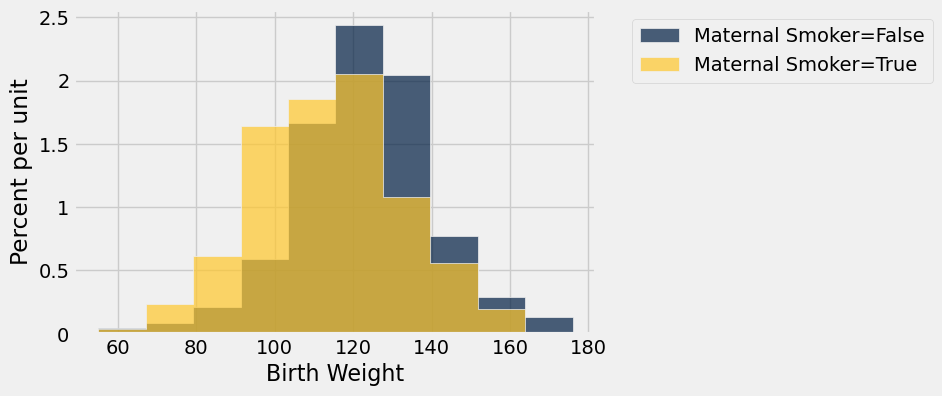

In [7]:
smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker') # SOLUTION

---

### The Groups and the Question

* Sample of mothers of newborns. Compare:
    * Birth weights of babies of mothers who didn't smoke
    * Birth weights of babies of mothers who smoked during pregnancy 
* Question: Could the differences we are observing be due to chance alone?


---

### Hypotheses

* Null Hypothesis: In the population, the distributions of the birth weights of the babies in the two groups are the same. (They are different in the sample just due to chance.)
* Alternative Hypothesis: In the population, the babies of the mothers who smoked during pregnancy weigh less, on average, than the babies of the non-smokers.


---

### Test Statistic

---

* Group A: non-smokers
* Group B: smokers
* Statistic: Difference between average weights: `group_B_mean - group_A_mean`  
* Negative values of this statistic favor the alternative


---

#### Demo: Test Statistic

Determine the average difference in the birth weights associated with mothers that did and didn't smoke during pregnancy.

Create a function that take name of table, column label of numerical variable, column label of group-label variable and returns the difference of means of the two groups.

In [8]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.mean)
means_table

Maternal Smoker,Birth Weight mean
False,123.085
True,113.819


In [9]:
means = means_table.column(1) # SOLUTION
observed_difference = means.item(1) - means.item(0) # SOLUTION
observed_difference

-9.266142572024918

In [10]:
def difference_of_means(table, value_label, group_label):
    """Takes: name of table, column value_label of numerical values,
    column group_label of group-label values (True/False)
    Returns: Difference (False_mean - True_mean) of means"""
    
    #table with the two relevant columns
    reduced = table.select(value_label, group_label) # SOLUTION
    
    # table containing group means
    means_table = reduced.group(group_label, np.mean) # SOLUTION
    
    # array of group means
    means = means_table.column(value_label + " mean") # SOLUTION
    
    return means.item(1) - means.item(0) # SOLUTION

In [11]:
""" # BEGIN PROMPT
difference_of_means(..., ..., ...)
"""; # END PROMPT
# BEGIN SOLUTION NO PROMPT
difference_of_means(births, 'Birth Weight', 'Maternal Smoker')
# END SOLUTION

-9.266142572024918

---

### The Data

<img src="./the_data.png" alt="a sequence of cribs with the data listed" width=80%>

---

### Shuffling Labels Under the Null

<img src="./shuffling_labels.png" alt="a sequence of cribs with the shuffled data listed" width=80%>

---

### Shuffling Rows

---

#### The `sample` table method.

* `tbl.sample(n)`: Table of `n` rows picked randomly with replacement
* `tbl.sample()`: Table with same number of rows as original `tbl`, picked randomly with replacement
* `tbl.sample(n, with_replacement = False)`: Table of `n` rows picked randomly without replacement
* `tbl.sample(with_replacement = False)`: All rows of `tbl`, in random order

---

#### Demo: Shuffling

Demonstrate how to perform a random permutation using the `sample` method.

In [12]:
letters = Table().with_column('Letter', make_array('a', 'b', 'c', 'd', 'e'))
letters

Letter
a
b
c
d
e


In [13]:
# most likely not a permutation
letters.sample() # SOLUTION

Letter
c
d
b
b
c


In [14]:
# a random permutation
letters.sample(with_replacement = False) # SOLUTION

Letter
c
b
d
a
e


In [15]:
shuffled_letters = letters.sample(with_replacement = False).column('Letter')
letters.with_column('Shuffled Letter', shuffled_letters)

Letter,Shuffled Letter
a,d
b,e
c,a
d,c
e,b


---

### Simulating Under the Null Hypothesis

---

* If the null is true, all rearrangements of labels are equally likely
* Plan:
    1. Shuffle all group labels
    1. Assign each shuffled label to a birth weight
    1. Find the difference between the averages of the two shuffled groups
    1. Repeat
* This process is generally called a permutation test.


---

#### Demo: Simulation Under Null Hypothesis

* Perform a random permutation on the table containing a Boolean-valued column representing whether or not the mother smoked during pregnancy and a integer-valued column of their baby's birth weight.
* Calculate the difference of the birth weight means for the two smoking groups based on the shuffled data and the original data.

In [16]:
smoking_and_birthweight.show(3)

Maternal Smoker,Birth Weight
False,120
False,113
True,128


In [17]:
""" # BEGIN PROMPT
shuffled_labels = ...
"""; # END PROMPT
# BEGIN SOLUTION NO PROMPT
shuffled_labels = (smoking_and_birthweight.
                   sample(with_replacement=False)
                   .column('Maternal Smoker'))
# END SOLUTION

In [18]:
original_and_shuffled = smoking_and_birthweight.with_column(
    'Shuffled Label', shuffled_labels)

original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Label
False,120,False
False,113,True
True,128,False
True,108,True
False,136,True
False,138,False
False,132,False
False,120,False
True,143,True
False,140,True


In [19]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Shuffled Label') # SOLUTION

-0.9848073495132326

In [20]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Maternal Smoker') # SOLUTION

-9.266142572024918

---

### Demo: Permutation Test

* Perform a permutation test using 2500 simulations to determine how likely it is to see the observed birth weights if it is assumed that there was no impact on birth weight due to the mother smoking or not during pregnancy. *This might take a few minutes to run.*
* Calculate the p-value.

In [21]:
""" # BEGIN PROMPT
def one_simulated_difference(table, value_label, group_label):
    '''Takes: name of table, column value_label of numerical variable,
    column group_label of group-label variable
    Returns: Difference of means of the two groups after shuffling group_labels'''
    
    # array of shuffled labels
    shuffled_labels = ...
    
    # table of numerical variable and shuffled labels
    shuffled_table = ...
    
    return ...   
"""; # END PROMPT
# BEGIN SOLUTION NO PROMPT
def one_simulated_difference(table, value_label, group_label):
    """Takes: name of table, column value_label of numerical variable,
    column group_label of group-label variable
    Returns: Difference of means of the two groups after shuffling group_labels"""
    
    # array of shuffled labels
    shuffled_labels = (table.sample(with_replacement = False)
                            .column(group_label))
    
    # table of numerical variable and shuffled labels
    shuffled_table = table.select(value_label).with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, value_label, 'Shuffled Label')   
# END SOLUTION

In [22]:
one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker') # SOLUTION

0.5856056797233293

In [23]:
differences = make_array()

for i in np.arange(2500):
    new_difference = one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker') # SOLUTION
    differences = np.append(differences, new_difference)

Observed Difference: -9.266142572024918


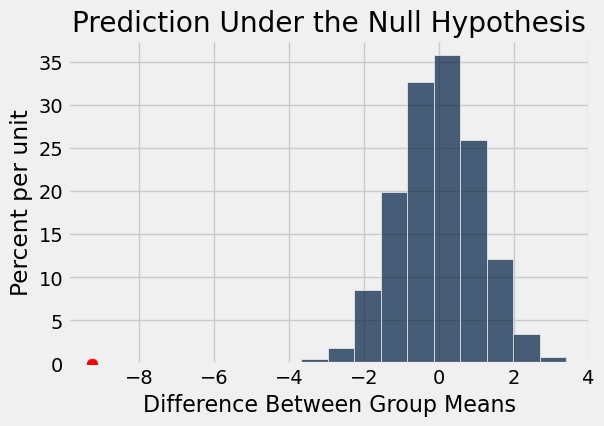

In [24]:
Table().with_column('Difference Between Group Means', differences).hist()
print('Observed Difference:', observed_difference)
plt.scatter(observed_difference, 0, color='red', s=60, zorder=3)
plt.title('Prediction Under the Null Hypothesis');

In [25]:
p_value = sum(differences <= observed_difference) / len(differences) # SOLUTION
p_value

0.0

---

### Conclusion

* With a p-value approximately 0%, we reject the null hypothesis and accept the alternative. 
* That is, in the population, the babies of the mothers who smoked during pregnancy weigh less, on average, than the babies of the non-smokers.

---

## Digital Experiments

---

* A/B tests are used in digital experiments. 
* Since they are typically easy to implement, it is common to find that multiple tests are actually run over a period of time.
* They can provide a methodical way to measure whether some new feature is having a statistically significant impact.
    * Advertising revenue
    * Click rate
    * etc.


<center>
    <a href="https://en.wikipedia.org/wiki/A/B_testing" title="Wikipedia - A/B Testing"><img src="./A-B_testing_example.png" alt="A comparision of two versions of a website design showing how the design might impact the click rate." width=60%></a>
</center>

---

## Hypothesis Testing Review

---

### Some Hypothesis Testing Situations

* 1 Sample: One Category (e.g. percent of flowers that are purple)
    * Test Statistic: `empirical_percent`, `abs(empirical_percent - null_percent)`
    * How to Simulate: `sample_proportions(n, null_dist)`
* 1 Sample: Multiple Categories (e.g. ethnicity distribution of jury panel)
    * Test Statistic: `tvd(empirical_dist, null_dist)`
    * How to Simulate: `sample_proportions(n, null_dist)`
* 1 Sample: Numerical Data (e.g. scores in a lab section)
    * Test Statistic: `empirical_mean`, `abs(empirical_mean - null_mean)`
    * How to Simulate: `population_data.sample(n, with_replacement=False)`
* 2 Samples: Numerical Data (e.g. birth weights of smokers vs. non-smokers)
    * Test Statistic: `group_a_mean - group_b_mean`, `group_b_mean - group_a_mean`, `abs(group_a_mean - group_b_mean)`
    * How to Simulate: `empirical_data.sample(with_replacement=False)`


--- 

## Attribution

This content is licensed under the <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License (CC BY-NC-SA 4.0)</a> and derived from the <a href="https://www.data8.org/">Data 8: The Foundations of Data Science</a> offered by the University of California, Berkeley.

<img src="./by-nc-sa.png" width=100px>